## Ocean memory estimates in ANHA4 NEMO simulation




In [1]:
import xarray as xr
import numpy as np
import scipy.stats as sc
import matplotlib.pyplot as plt
import glob
import xskillscore as xs

import matplotlib.image as image
import matplotlib.patches as patches

import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmaps
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import warnings
warnings.filterwarnings("ignore")

/home/users/hkhatri/miniforge3/envs/xarray/lib/python3.13/site-packages/pyproj/network.py:59: UserWarning: pyproj unable to set PROJ database path.
  _set_context_ca_bundle_path(ca_bundle_path)


In [2]:
def detrend_dim(da, dim, deg=1):
    # detrend along a single dimension
    p = da.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    return da - fit

def detrend(da, dims, deg=1):
    # detrend along multiple dimensions
    # only valid for linear detrending (deg=1)
    da_detrended = da
    for dim in dims:
        da_detrended = detrend_dim(da_detrended, dim, deg=deg)
    return da_detrended

def Moving_Avg(ds, time = 1., time_len = 12):
    
    """Compute moving averages
    Parameters
    ----------
    ds : xarray Dataset for data variables
    time : time values for computing weights
    time_len : number of grid points for moving avg
    
    Returns
    -------
    ds_avg : Dataset containting moving avg
    """
    
    if(len(time) == 1):
        
        ds_avg = ds.rolling(time = time_len, center = True).mean('time')
        
    else: 
    
        days = time.dt.daysinmonth
        
        ds_avg = ((ds * days).rolling(time = time_len, center = True).mean('time') /
                  days.rolling(time = time_len, center = True).mean('time'))
    
    return ds_avg

## Reconstructions from air-sea heat flux timseries

In [3]:
# Read data

ppdir = "/gws/nopw/j04/snapdragon/hkhatri/HighResMIP/NEMO_UAlberta/Memory-ANHA4-EPM111/"

ds = xr.open_dataset(ppdir +"Recons_green_function/Response_heat_flux.nc")
ds = ds.sel(time = ds['time.year'] >= 1979) # ignore previous 20 years

var_list = ['votemper_subpolar_NAtl', 'votemper_arctic', 'ileadfra', 'Pred_arctic', 'Pred_subpolar_Atl']

# annul-means and remove linear trends
days = ds['time'].dt.days_in_month
weights = days.groupby('time.year') / days.groupby('time.year').sum(dim='time')
ds = (ds * weights).groupby('time.year').sum(dim='time')

for var in var_list:
    ds[var] = detrend(ds[var], ['year'])

ds = ds.rename({'year':'time'})

print(ds)

<xarray.Dataset> Size: 3MB
Dimensions:                 (time: 43, gamma: 40, beta: 21, y: 520, x: 544)
Coordinates:
    lat                     (y, x) float32 1MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    lon                     (y, x) float32 1MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
  * gamma                   (gamma) float64 320B 0.5 1.0 1.5 ... 19.0 19.5 20.0
  * beta                    (beta) float64 168B 0.0 0.5 1.0 1.5 ... 9.0 9.5 10.0
  * time                    (time) int64 344B 1979 1980 1981 ... 2019 2020 2021
Dimensions without coordinates: y, x
Data variables:
    votemper_subpolar_NAtl  (time) float64 344B 1.337e+15 ... 9.672e+13
    votemper_arctic         (time) float64 344B 3.974e+14 5.21e+14 ... 1.368e+14
    ice_vol                 (time) float64 344B 3.289e+12 ... -1.851e+12
    ileadfra                (time) float64 344B -1.42e+11 ... 2.101e+10
    sohefldo_subpolar_NAtl  (time) float64 344B 7.073e+13 ... 5.332e+13
    sohefldo_arctic         (time) float64 344B 3.85e+13 3.626

Text(0.1, 0.15, 'Ocean Memory = 12.01$\\pm$1.1 years')

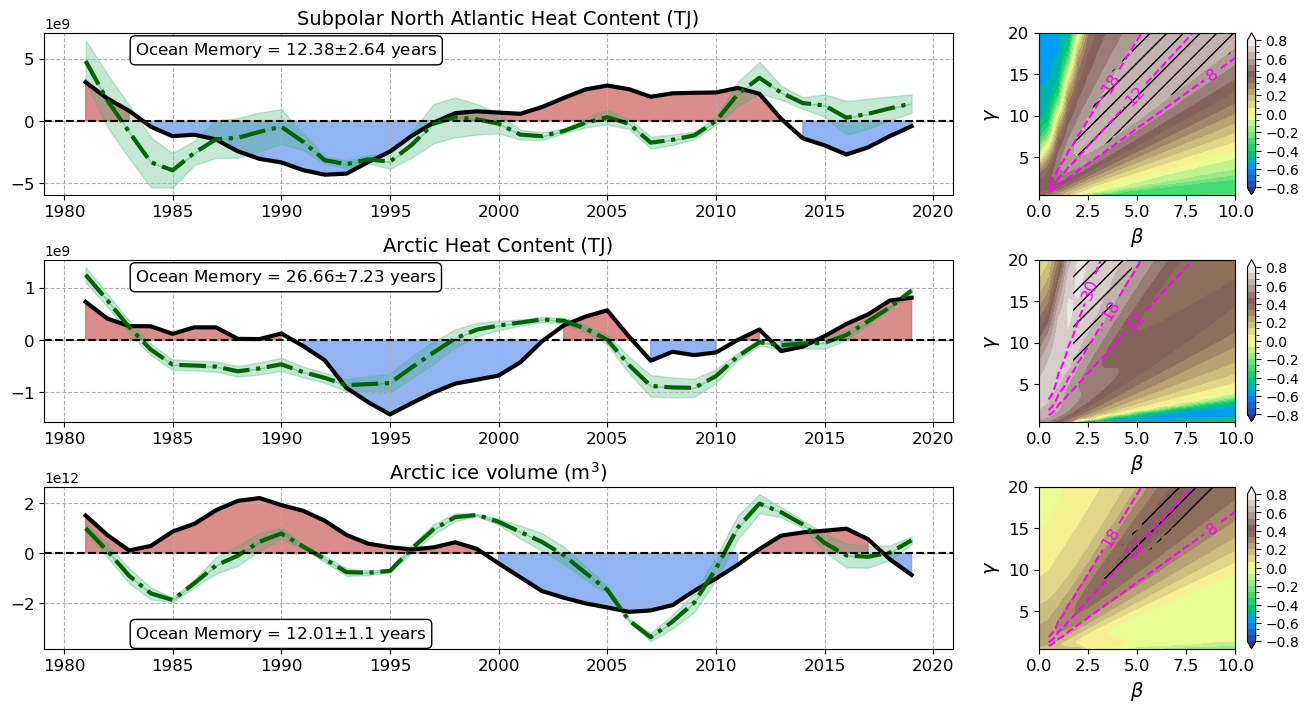

In [50]:
grid1 = plt.GridSpec(3, 4, wspace=0.35, hspace=0.4)
fig = plt.figure(figsize=[16,8])

rho_cp = 4.09*1.e6
hatch_dense = 2
fs =14

gamma_beta = ds['gamma'] * 1.5 * np.pi / ds['beta'] # all possible memory timescales

fac =  4.09*1.e6 / 1.e12 # factor to convert heat content into tera joules

### Subpolar North Atlantic heat content ------------
ax = fig.add_subplot(grid1[0, 3])

corr_r = xs.pearson_r(ds['Pred_subpolar_Atl'], ds['votemper_subpolar_NAtl'] * fac, 
                     dim='time', skipna=True) 
corr_p = xs.pearson_r_p_value(ds['Pred_subpolar_Atl'], ds['votemper_subpolar_NAtl'] * fac, 
                             dim='time', skipna=True)

p = corr_r.plot.contourf(ax=ax, x='beta', y='gamma', levels = 25, vmin = -.8, vmax = .8,
                        cmap='terrain', add_labels=False, add_colorbar=True, extend='both')

# Choose gamm-beta for anomaly reconstruction (set gamma >= 1. and corr. > 0.6)
cor_max = (corr_r).where(corr_r==corr_r.max(), drop=True).squeeze()
gamma_beta_max = cor_max['gamma'].values * 1.5 * np.pi / cor_max['beta'].values

mem_chose = corr_r.where((corr_r > 0.6) & (corr_r['gamma']>= 1.))
mem_chose = mem_chose.where(gamma_beta < -corr_r['gamma'] * np.log(0.05)) # to ensure memory < 3*gamma, 95% damping of anomalies 
mem_chose = mem_chose.where(corr_p < 0.01) # significance levels at 99%

ax.contourf(ds['beta'], ds['gamma'], ((mem_chose<1.) & (mem_chose>-1.)), colors='none', 
            levels=[.5,1.,1.5, 2.], hatches=[hatch_dense*'/'], extend='upper')

# ocean memory isolines
CS = ax.contour(ds['beta'], ds['gamma'], gamma_beta, [8., 12., 18.], linewidths=1.5, linestyles='--', colors='magenta')
ax.clabel(CS, CS.levels, inline=True, fontsize=12)

ax.set_xlabel(r'$\beta$', fontsize=fs)
ax.set_ylabel(r'$\gamma$', fontsize=fs)
plt.xticks(fontsize=12); plt.yticks(fontsize=12);


ax = fig.add_subplot(grid1[0, 0:3])
tmp = Moving_Avg(ds['votemper_subpolar_NAtl'] * fac, time = [1.], time_len = 5)

ax.plot(ds['time'], tmp, lw=3.0, ls='-', color='k', label='Actual')
ax.fill_between(ds['time'], tmp.where(tmp < 0), alpha=0.7, color='cornflowerblue')
ax.fill_between(ds['time'], tmp.where(tmp > 0), alpha=0.7, color='indianred')

tmp_pred = Moving_Avg(ds['Pred_subpolar_Atl'], time = [1.], time_len = 5)
tmp_pred1 = tmp_pred.where((mem_chose<1.) & (mem_chose>-1.))

tmp_pred1 = tmp_pred1 * tmp.std('time') / tmp_pred1.std('time')
std_error = tmp_pred1.std(['gamma', 'beta'])
tmp_mean = tmp_pred1.mean(['gamma', 'beta']).compute()

ax.plot(ds['time'], tmp_mean, lw=3.0, ls='-.', 
        color='darkgreen', label='Recons. (local and farfield effects)')
ax.fill_between(ds['time'], tmp_mean, tmp_mean + std_error, alpha=0.3, color='mediumseagreen')
ax.fill_between(ds['time'], tmp_mean, tmp_mean - std_error, alpha=0.3, color='mediumseagreen')

ax.grid(ls='--')
ax.axhline(y=0., ls='--', color='k')
plt.xticks(fontsize=12); plt.yticks(fontsize=12);
ax.set_title(r'Subpolar North Atlantic Heat Content (TJ)', fontsize=fs);

memory = gamma_beta.where((mem_chose<1.) & (mem_chose>-1.))
props = dict(boxstyle='round', facecolor='white', alpha=1.)
txt = (r'Ocean Memory = ' + str(np.round(memory.mean(['gamma', 'beta']).values,2)) + 
       r'$\pm$' + str(np.round(memory.std(['gamma', 'beta']).values,2)) + ' years')
ax.text(0.1, 0.95, txt, transform=ax.transAxes, fontsize=12, color='black', verticalalignment='top', bbox=props)

### Arctic heat content ------------
ax = fig.add_subplot(grid1[1, 3])

corr_r = xs.pearson_r(ds['Pred_arctic'], ds['votemper_arctic'] * fac, 
                     dim='time', skipna=True) 
corr_p = xs.pearson_r_p_value(ds['Pred_arctic'], ds['votemper_arctic'] * fac, 
                             dim='time', skipna=True)

p = corr_r.plot.contourf(ax=ax, x='beta', y='gamma', levels = 25, vmin = -.8, vmax = .8,
                        cmap='terrain', add_labels=False, add_colorbar=True, extend='both')

# Choose gamm-beta for anomaly reconstruction (set gamma >= 1. and corr. > 0.6)
cor_max = (corr_r).where(corr_r==corr_r.max(), drop=True).squeeze()
gamma_beta_max = cor_max['gamma'].values * 1.5 * np.pi / cor_max['beta'].values

mem_chose = corr_r.where((corr_r > 0.6) & (corr_r['gamma']>= 1.))
mem_chose = mem_chose.where(gamma_beta < -corr_r['gamma'] * np.log(0.05)) # to ensure memory < 3*gamma, 95% damping of anomalies 
mem_chose = mem_chose.where(corr_p < 0.01) # significance levels at 99%

ax.contourf(ds['beta'], ds['gamma'], ((mem_chose<1.) & (mem_chose>-1.)), colors='none', 
            levels=[.5,1.,1.5, 2.], hatches=[hatch_dense*'/'], extend='upper')

# ocean memory isolines
CS = ax.contour(ds['beta'], ds['gamma'], gamma_beta, [12., 18., 30.], linewidths=1.5, linestyles='--', colors='magenta')
ax.clabel(CS, CS.levels, inline=True, fontsize=12)

ax.set_xlabel(r'$\beta$', fontsize=fs)
ax.set_ylabel(r'$\gamma$', fontsize=fs)
plt.xticks(fontsize=12); plt.yticks(fontsize=12);

ax = fig.add_subplot(grid1[1, 0:3])
tmp = Moving_Avg(ds['votemper_arctic'] * fac, time = [1.], time_len = 5)

ax.plot(ds['time'], tmp, lw=3.0, ls='-', color='k', label='Actual')
ax.fill_between(ds['time'], tmp.where(tmp < 0), alpha=0.7, color='cornflowerblue')
ax.fill_between(ds['time'], tmp.where(tmp > 0), alpha=0.7, color='indianred')

tmp_pred = Moving_Avg(ds['Pred_arctic'], time = [1.], time_len = 5)
tmp_pred1 = tmp_pred.where((mem_chose<1.) & (mem_chose>-1.))

tmp_pred1 = tmp_pred1 * tmp.std('time') / tmp_pred1.std('time')
std_error = tmp_pred1.std(['gamma', 'beta'])
tmp_mean = tmp_pred1.mean(['gamma', 'beta']).compute()

ax.plot(ds['time'], tmp_mean, lw=3.0, ls='-.', 
        color='darkgreen', label='Recons. (local and farfield effects)')
ax.fill_between(ds['time'], tmp_mean, tmp_mean + std_error, alpha=0.3, color='mediumseagreen')
ax.fill_between(ds['time'], tmp_mean, tmp_mean - std_error, alpha=0.3, color='mediumseagreen')

ax.grid(ls='--')
ax.axhline(y=0., ls='--', color='k')
plt.xticks(fontsize=12); plt.yticks(fontsize=12);
ax.set_title(r'Arctic Heat Content (TJ)', fontsize=fs);

memory = gamma_beta.where((mem_chose<1.) & (mem_chose>-1.))
props = dict(boxstyle='round', facecolor='white', alpha=1.)
txt = (r'Ocean Memory = ' + str(np.round(memory.mean(['gamma', 'beta']).values,2)) + 
       r'$\pm$' + str(np.round(memory.std(['gamma', 'beta']).values,2)) + ' years')
ax.text(0.1, 0.95, txt, transform=ax.transAxes, fontsize=12, color='black', verticalalignment='top', bbox=props)


### Arctic ice volume ------------
ax = fig.add_subplot(grid1[2, 3])

corr_r = xs.pearson_r(ds['Pred_arctic'], ds['ice_vol'], 
                     dim='time', skipna=True) 
corr_p = xs.pearson_r_p_value(ds['Pred_arctic'], ds['ice_vol'], 
                             dim='time', skipna=True)

p = corr_r.plot.contourf(ax=ax, x='beta', y='gamma', levels = 25, vmin = -.8, vmax = .8,
                        cmap='terrain', add_labels=False, add_colorbar=True, extend='both')

# Choose gamm-beta for anomaly reconstruction (set gamma >= 1. and corr. > 0.35)
cor_max = (corr_r).where(corr_r==corr_r.max(), drop=True).squeeze()
gamma_beta_max = cor_max['gamma'].values * 1.5 * np.pi / cor_max['beta'].values

mem_chose = corr_r.where((corr_r > 0.35) & (corr_r['gamma']>= 1.))
mem_chose = mem_chose.where(gamma_beta < -corr_r['gamma'] * np.log(0.05)) # to ensure memory < 3*gamma, 95% damping of anomalies 
mem_chose = mem_chose.where(corr_p < 0.01) # significance levels at 99%

ax.contourf(ds['beta'], ds['gamma'], ((mem_chose<1.) & (mem_chose>-1.)), colors='none', 
            levels=[.5,1.,1.5, 2.], hatches=[hatch_dense*'/'], extend='upper')

# ocean memory isolines
CS = ax.contour(ds['beta'], ds['gamma'], gamma_beta, [8., 12., 18.], linewidths=1.5, linestyles='--', colors='magenta')
ax.clabel(CS, CS.levels, inline=True, fontsize=12)

ax.set_xlabel(r'$\beta$', fontsize=fs)
ax.set_ylabel(r'$\gamma$', fontsize=fs)
plt.xticks(fontsize=12); plt.yticks(fontsize=12);

ax = fig.add_subplot(grid1[2, 0:3])
tmp = Moving_Avg(ds['ice_vol'], time = [1.], time_len = 5)

ax.plot(ds['time'], tmp, lw=3.0, ls='-', color='k', label='Actual')
ax.fill_between(ds['time'], tmp.where(tmp < 0), alpha=0.7, color='cornflowerblue')
ax.fill_between(ds['time'], tmp.where(tmp > 0), alpha=0.7, color='indianred')

tmp_pred = Moving_Avg(ds['Pred_arctic'], time = [1.], time_len = 5)
tmp_pred1 = tmp_pred.where((mem_chose<1.) & (mem_chose>-1.))

tmp_pred1 = tmp_pred1 * tmp.std('time') / tmp_pred1.std('time')
std_error = tmp_pred1.std(['gamma', 'beta'])
tmp_mean = tmp_pred1.mean(['gamma', 'beta']).compute()

ax.plot(ds['time'], tmp_mean, lw=3.0, ls='-.', 
        color='darkgreen', label='Recons. (local and farfield effects)')
ax.fill_between(ds['time'], tmp_mean, tmp_mean + std_error, alpha=0.3, color='mediumseagreen')
ax.fill_between(ds['time'], tmp_mean, tmp_mean - std_error, alpha=0.3, color='mediumseagreen')

ax.grid(ls='--')
ax.axhline(y=0., ls='--', color='k')
plt.xticks(fontsize=12); plt.yticks(fontsize=12);
ax.set_title(r'Arctic ice volume (m$^3$)', fontsize=fs);

memory = gamma_beta.where((mem_chose<1.) & (mem_chose>-1.))
props = dict(boxstyle='round', facecolor='white', alpha=1.)
txt = (r'Ocean Memory = ' + str(np.round(memory.mean(['gamma', 'beta']).values,2)) + 
       r'$\pm$' + str(np.round(memory.std(['gamma', 'beta']).values,2)) + ' years')
ax.text(0.1, 0.15, txt, transform=ax.transAxes, fontsize=12, color='black', verticalalignment='top', bbox=props)

Text(0.1, 0.15, 'Ocean Memory = nan$\\pm$nan years')

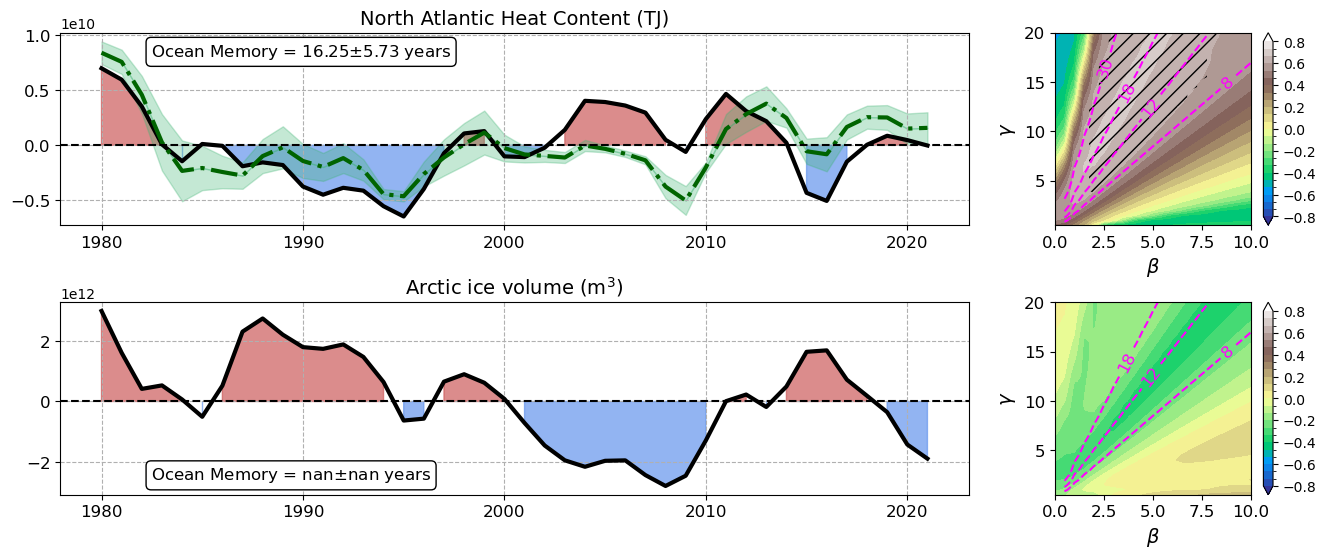

In [56]:
# Combine subpolar and Arctic together 

grid1 = plt.GridSpec(2, 4, wspace=0.35, hspace=0.4)
fig = plt.figure(figsize=[16,6])

rho_cp = 4.09*1.e6
hatch_dense = 2
fs =14

gamma_beta = ds['gamma'] * 1.5 * np.pi / ds['beta'] # all possible memory timescales

fac =  4.09*1.e6 / 1.e12 # factor to convert heat content into tera joules

### North Atlantic heat content (north of 45N) ------------
ax = fig.add_subplot(grid1[0, 3])

corr_r = xs.pearson_r(ds['Pred_subpolar_Atl'] + ds['Pred_arctic'], (ds['votemper_subpolar_NAtl'] + ds['votemper_arctic']) * fac, 
                     dim='time', skipna=True) 
corr_p = xs.pearson_r_p_value(ds['Pred_subpolar_Atl'] + ds['Pred_arctic'], (ds['votemper_subpolar_NAtl'] + ds['votemper_arctic']) * fac,
                             dim='time', skipna=True)

p = corr_r.plot.contourf(ax=ax, x='beta', y='gamma', levels = 25, vmin = -.8, vmax = .8,
                        cmap='terrain', add_labels=False, add_colorbar=True, extend='both')

# Choose gamm-beta for anomaly reconstruction (set gamma >= 1. and corr. > 0.6)
cor_max = (corr_r).where(corr_r==corr_r.max(), drop=True).squeeze()
gamma_beta_max = cor_max['gamma'].values * 1.5 * np.pi / cor_max['beta'].values

mem_chose = corr_r.where((corr_r > 0.6) & (corr_r['gamma']>= 1.))
mem_chose = mem_chose.where(gamma_beta < -corr_r['gamma'] * np.log(0.05)) # to ensure memory < 3*gamma, 95% damping of anomalies 
mem_chose = mem_chose.where(corr_p < 0.01) # significance levels at 99%

ax.contourf(ds['beta'], ds['gamma'], ((mem_chose<1.) & (mem_chose>-1.)), colors='none', 
            levels=[.5,1.,1.5, 2.], hatches=[hatch_dense*'/'], extend='upper')

# ocean memory isolines
CS = ax.contour(ds['beta'], ds['gamma'], gamma_beta, [8., 12., 18., 30.], linewidths=1.5, linestyles='--', colors='magenta')
ax.clabel(CS, CS.levels, inline=True, fontsize=12)

ax.set_xlabel(r'$\beta$', fontsize=fs)
ax.set_ylabel(r'$\gamma$', fontsize=fs)
plt.xticks(fontsize=12); plt.yticks(fontsize=12);


ax = fig.add_subplot(grid1[0, 0:3])
tmp = Moving_Avg((ds['votemper_subpolar_NAtl'] + ds['votemper_arctic'])* fac, time = [1.], time_len = 2)

ax.plot(ds['time'], tmp, lw=3.0, ls='-', color='k', label='Actual')
ax.fill_between(ds['time'], tmp.where(tmp < 0), alpha=0.7, color='cornflowerblue')
ax.fill_between(ds['time'], tmp.where(tmp > 0), alpha=0.7, color='indianred')

tmp_pred = Moving_Avg(ds['Pred_subpolar_Atl'] + ds['Pred_arctic'], time = [1.], time_len = 2)
tmp_pred1 = tmp_pred.where((mem_chose<1.) & (mem_chose>-1.))

tmp_pred1 = tmp_pred1 * tmp.std('time') / tmp_pred1.std('time')
std_error = tmp_pred1.std(['gamma', 'beta'])
tmp_mean = tmp_pred1.mean(['gamma', 'beta']).compute()

ax.plot(ds['time'], tmp_mean, lw=3.0, ls='-.', 
        color='darkgreen', label='Recons. (local and farfield effects)')
ax.fill_between(ds['time'], tmp_mean, tmp_mean + std_error, alpha=0.3, color='mediumseagreen')
ax.fill_between(ds['time'], tmp_mean, tmp_mean - std_error, alpha=0.3, color='mediumseagreen')

ax.grid(ls='--')
ax.axhline(y=0., ls='--', color='k')
plt.xticks(fontsize=12); plt.yticks(fontsize=12);
ax.set_title(r'North Atlantic Heat Content (TJ)', fontsize=fs);

memory = gamma_beta.where((mem_chose<1.) & (mem_chose>-1.))
props = dict(boxstyle='round', facecolor='white', alpha=1.)
txt = (r'Ocean Memory = ' + str(np.round(memory.mean(['gamma', 'beta']).values,2)) + 
       r'$\pm$' + str(np.round(memory.std(['gamma', 'beta']).values,2)) + ' years')
ax.text(0.1, 0.95, txt, transform=ax.transAxes, fontsize=12, color='black', verticalalignment='top', bbox=props)


### Arctic ice volume ------------
ax = fig.add_subplot(grid1[1, 3])

corr_r = xs.pearson_r(-ds['Pred_subpolar_Atl'] - ds['Pred_arctic'], ds['ice_vol'], 
                     dim='time', skipna=True) 
corr_p = xs.pearson_r_p_value(-ds['Pred_subpolar_Atl'] - ds['Pred_arctic'], ds['ice_vol'], 
                             dim='time', skipna=True)

p = corr_r.plot.contourf(ax=ax, x='beta', y='gamma', levels = 25, vmin = -.8, vmax = .8,
                        cmap='terrain', add_labels=False, add_colorbar=True, extend='both')

# Choose gamm-beta for anomaly reconstruction (set gamma >= 1. and corr. > 0.35)
cor_max = (corr_r).where(corr_r==corr_r.max(), drop=True).squeeze()
gamma_beta_max = cor_max['gamma'].values * 1.5 * np.pi / cor_max['beta'].values

mem_chose = corr_r.where((corr_r > 0.35) & (corr_r['gamma']>= 1.))
mem_chose = mem_chose.where(gamma_beta < -corr_r['gamma'] * np.log(0.05)) # to ensure memory < 3*gamma, 95% damping of anomalies 
mem_chose = mem_chose.where(corr_p < 0.01) # significance levels at 99%

ax.contourf(ds['beta'], ds['gamma'], ((mem_chose<1.) & (mem_chose>-1.)), colors='none', 
            levels=[.5,1.,1.5, 2.], hatches=[hatch_dense*'/'], extend='upper')

# ocean memory isolines
CS = ax.contour(ds['beta'], ds['gamma'], gamma_beta, [8., 12., 18.], linewidths=1.5, linestyles='--', colors='magenta')
ax.clabel(CS, CS.levels, inline=True, fontsize=12)

ax.set_xlabel(r'$\beta$', fontsize=fs)
ax.set_ylabel(r'$\gamma$', fontsize=fs)
plt.xticks(fontsize=12); plt.yticks(fontsize=12);

ax = fig.add_subplot(grid1[1, 0:3])
tmp = Moving_Avg(ds['ice_vol'], time = [1.], time_len = 2)

ax.plot(ds['time'], tmp, lw=3.0, ls='-', color='k', label='Actual')
ax.fill_between(ds['time'], tmp.where(tmp < 0), alpha=0.7, color='cornflowerblue')
ax.fill_between(ds['time'], tmp.where(tmp > 0), alpha=0.7, color='indianred')

tmp_pred = Moving_Avg(ds['Pred_subpolar_Atl'] + ds['Pred_arctic'], time = [1.], time_len = 2)
tmp_pred1 = tmp_pred.where((mem_chose<1.) & (mem_chose>-1.))

tmp_pred1 = tmp_pred1 * tmp.std('time') / tmp_pred1.std('time')
std_error = tmp_pred1.std(['gamma', 'beta'])
tmp_mean = tmp_pred1.mean(['gamma', 'beta']).compute()

ax.plot(ds['time'], tmp_mean, lw=3.0, ls='-.', 
        color='darkgreen', label='Recons. (local and farfield effects)')
ax.fill_between(ds['time'], tmp_mean, tmp_mean + std_error, alpha=0.3, color='mediumseagreen')
ax.fill_between(ds['time'], tmp_mean, tmp_mean - std_error, alpha=0.3, color='mediumseagreen')

ax.grid(ls='--')
ax.axhline(y=0., ls='--', color='k')
plt.xticks(fontsize=12); plt.yticks(fontsize=12);
ax.set_title(r'Arctic ice volume (m$^3$)', fontsize=fs);

memory = gamma_beta.where((mem_chose<1.) & (mem_chose>-1.))
props = dict(boxstyle='round', facecolor='white', alpha=1.)
txt = (r'Ocean Memory = ' + str(np.round(memory.mean(['gamma', 'beta']).values,2)) + 
       r'$\pm$' + str(np.round(memory.std(['gamma', 'beta']).values,2)) + ' years')
ax.text(0.1, 0.15, txt, transform=ax.transAxes, fontsize=12, color='black', verticalalignment='top', bbox=props)

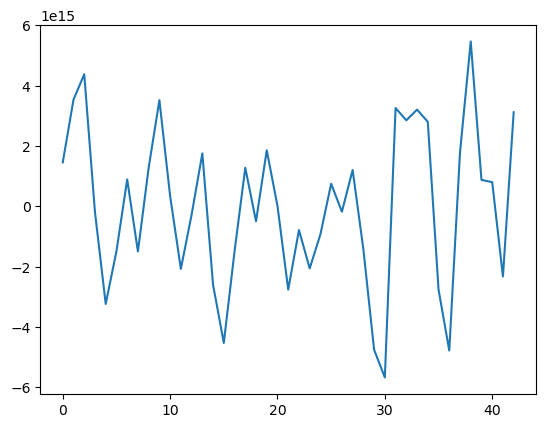

In [24]:
ds['Pred_subpolar_Atl']
plt.plot(ds['Pred_subpolar_Atl'].isel(beta=2, gamma=4))

In [26]:
tmp = ds['votemper_subpolar_NAtl'] * fac
tmp_r = xs.pearson_r(ds['Pred_subpolar_Atl'], tmp, 
                     dim='year', skipna=True) 

In [27]:
tmp_r

<xarray.DataArray (gamma: 40, beta: 21)> Size: 7kB
array([[ 0.32528338,  0.28241966,  0.18822164,  0.09549984, -0.05736524,
        -0.25214677, -0.34274044, -0.36566063, -0.36350397, -0.3519033 ,
        -0.33720977, -0.32128715, -0.30470539, -0.28810971, -0.27205528,
        -0.25741783, -0.24444368, -0.2322856 , -0.2205422 , -0.20934065,
        -0.19769971],
       [ 0.39948821,  0.37906442,  0.29158244,  0.17745946,  0.07765074,
         0.00449659, -0.05944272, -0.14213525, -0.23233915, -0.29081495,
        -0.32260974, -0.34009679, -0.34975306, -0.35438526, -0.35553653,
        -0.35422052, -0.35109252, -0.34661757, -0.34133579, -0.33554962,
        -0.3294115 ],
       [ 0.41729537,  0.42925919,  0.38761544,  0.28479079,  0.17768842,
         0.09030527,  0.01572984, -0.03888411, -0.0782226 , -0.12030319,
        -0.16930811, -0.22277019, -0.26792493, -0.29734785, -0.3149461 ,
        -0.3278446 , -0.33683902, -0.34316885, -0.34748017, -0.35017361,
        -0.35152999],
       [ 0.40143576,  0.44516525,  0.45199887,  0.3798855 ,  0.27664188,
         0.1810494 ,  0.10238737,  0.03888761, -0.01768895, -0.06055129,
        -0.09038704, -0.11799571, -0.14836263, -0.18204764, -0.21826348,
        -0.25316947, -0.28060422, -0.29970085, -0.31176667, -0.32117914,
        -0.32889808],
...
       [-0.54762954, -0.54744985, -0.53807069, -0.42368029,  0.09505093,
         0.36703633,  0.4514615 ,  0.49701759,  0.53618319,  0.57981257,
         0.61374677,  0.63389664,  0.64305063,  0.64862202,  0.64865483,
         0.64551105,  0.64429255,  0.64343687,  0.63775384,  0.62480296,
         0.60366685],
       [-0.54819041, -0.54827283, -0.54124331, -0.45015828,  0.03949856,
         0.34881528,  0.4422288 ,  0.48933426,  0.52735786,  0.56904382,
         0.60598424,  0.62926611,  0.64054227,  0.64692516,  0.64908169,
         0.64676953,  0.64429376,  0.64406483,  0.64149302,  0.63238184,
         0.61600093],
       [-0.54867382, -0.54896971, -0.54383674, -0.47142422, -0.01967399,
         0.32862266,  0.43265423,  0.4818584 ,  0.51918271,  0.55831802,
         0.59774626,  0.62371633,  0.63786147,  0.6448302 ,  0.64890641,
         0.64779098,  0.64477161,  0.64417211,  0.64331342,  0.63778734,
         0.6256668 ],
       [-0.54909063, -0.54956017, -0.54596336, -0.4884485 , -0.0808893 ,
         0.30613296,  0.42262994,  0.47450535,  0.51153633,  0.54852617,
         0.5888886 ,  0.61756938,  0.63460563,  0.64261288,  0.64788251,
         0.64845994,  0.64581548,  0.64405016,  0.64392077,  0.64134351,
         0.63270369]])
Coordinates:
  * gamma    (gamma) float64 320B 0.5 1.0 1.5 2.0 2.5 ... 18.5 19.0 19.5 20.0
  * beta     (beta) float64 168B 0.0 0.5 1.0 1.5 2.0 ... 8.0 8.5 9.0 9.5 10.0